# Data Model

The [data model](../_autosummary/photonforge.DataModel.rst) is used when the [S parameters](S_Parameters.rst) for a component are available as value arrays, for example, loaded from a Touchstone (*snp*) file.
This type of model allows the use of data imported from alternative sources and, in particular, experimental data to be used for simulation.

In [1]:
import numpy as np
import photonforge as pf
from matplotlib import pyplot as plt

pf.config.default_technology = pf.basic_technology()

## Sample Data Generation

For practical reasons, we'll first create a Touchstone file with data from a [Tidy3D model](Tidy3D_Model.rst) simulation, instead of running an actual experiment.
The following component is not practical, but it is a small example that provides an interesting S parameter curve.

In [2]:
component = pf.Component("MAIN")

component.add(
    "WG_CORE",
    pf.Path((0, -2.5), 0.5)
    .segment((0, -2))
    .segment((0, -1.5), 0.2)
    .segment((0, 1.5))
    .segment((0, 2), 0.5)
    .segment((0, 2.5)),
    "SLAB",
    *[pf.Rectangle(center=(0, i * 0.4), size=(2, 0.25)) for i in range(-4, 5)]
)

component.add("WG_CLAD", pf.envelope(component, 1, trim_y_min=True, trim_y_max=True))

component.add_port(component.detect_ports())

component.add_model(pf.Tidy3DModel(port_symmetries=[("P1", "P0", {"P0": "P1"})]), "Tidy3D")

component

The S matrix values will be computed using 21 equally-spaced points in wavelength domain:

Starting...
Loading cached simulation from .tidy3d/pf_cache/SWB/fdtd_info-K3DFMOHNAP4PMBG7ULTLI4VDJ7QT4FQSYYEP3WKVDUC4YD7RUAJA.json.
Progress: 100% 


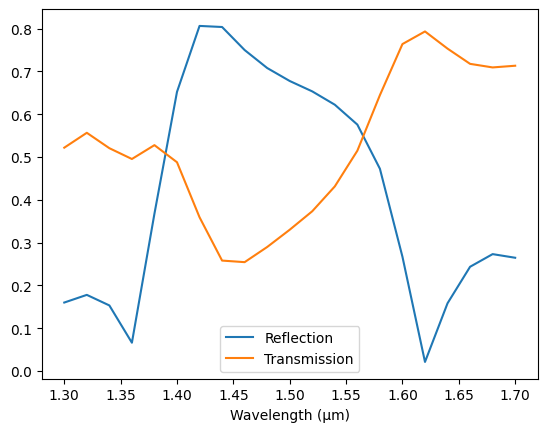

In [3]:
s_matrix = component.s_matrix(pf.C_0 / np.linspace(1.3, 1.7, 21))

plt.plot(pf.C_0 / s_matrix.frequencies, np.abs(s_matrix["P0@0", "P0@0"]), label="Reflection")
plt.plot(pf.C_0 / s_matrix.frequencies, np.abs(s_matrix["P0@0", "P1@0"]), label="Transmission")
plt.xlabel("Wavelength (μm)")
_ = plt.legend()

The data is [written](../_autosummary/photonforge.SMatrix.rst#photonforge.SMatrix.write_snp) to a Touchstone file to be loaded as if it were experimental data.

In [4]:
_ = s_matrix.write_snp("data.s2p")

## Loading S Matrix Data

Loading Touchstone files can be done with the [load_snp](../_autosummary/photonforge.load_snp.rst) function or the [SMatrix.load_snp](../_autosummary/photonforge.SMatrix.rst#photonforge.SMatrix.load_snp) method.
The former returns an array with the S matrix values and another with their corresponding frequencies, and the latter creates an S matrix object directly and is usually easier to use.

In [5]:
loaded_s_matrix = pf.SMatrix.load_snp("data.s2p")

data_model = pf.DataModel(loaded_s_matrix, interpolation_method="linear")

The data model can be used just as any other model to generate S parameters for the component they are assigned to.
The only condition that must be respected is that the number of ports/modes of the component must match the model's.

For example, we can create a black-box components and use our experimental data model to include the component in larger systems with [circuit models](Circuit_Model.rst).

In [6]:
black_box = pf.Component("BB")

black_box.add_port(pf.Port((0, 0), 0, "Strip"), "P0")
black_box.add_port(pf.Port((1, 0), 180, "Rib"), "P1")

black_box.add_model(data_model, "Data")

black_box

Starting...
Progress: 100% 


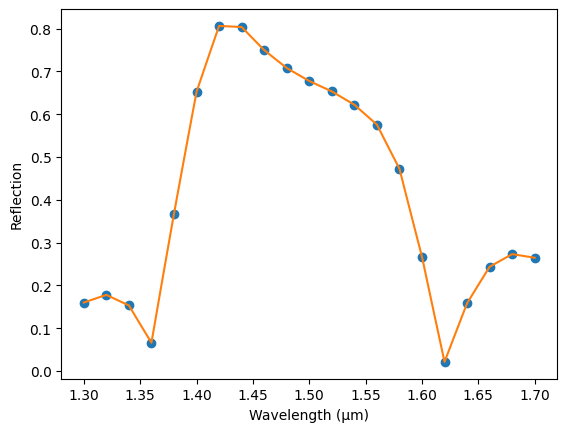

In [7]:
s_data = black_box.s_matrix(pf.C_0 / np.linspace(1.3, 1.7, 101))

plt.plot(pf.C_0 / s_matrix.frequencies, np.abs(s_matrix["P0@0", "P0@0"]), "o")
plt.plot(pf.C_0 / s_data.frequencies, np.abs(s_data["P0@0", "P0@0"]))
plt.xlabel("Wavelength (μm)")
_ = plt.ylabel("Reflection")

## Interpolation

Note that the S matrix retrieved from the data model earlier used a different set of frequency points from the original.
The data model computes the S parameters using linear interpolation by default, but that can be easily changed to a few other methods, documented in the [data model](../_autosummary/photonforge.DataModel.rst) constructor.
Let's use the `"akima"` method for a smoother interpolation:

Starting...
Progress: 100% 


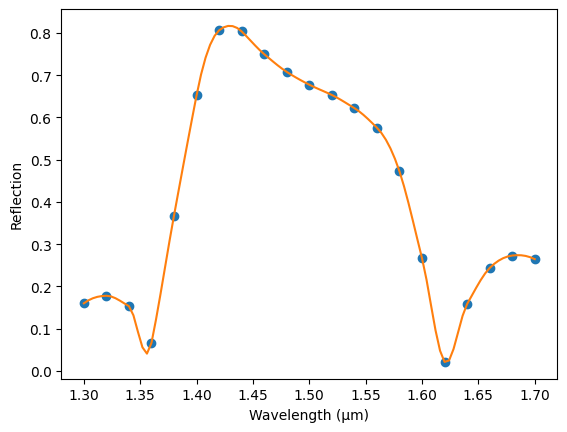

In [8]:
model = pf.DataModel(loaded_s_matrix, interpolation_method="akima")

s_data = model.s_matrix(component, pf.C_0 / np.linspace(1.3, 1.7, 101))

plt.plot(pf.C_0 / s_matrix.frequencies, np.abs(s_matrix["P0@0", "P0@0"]), "o")
plt.plot(pf.C_0 / s_data.frequencies, np.abs(s_data["P0@0", "P0@0"]))
plt.xlabel("Wavelength (μm)")
_ = plt.ylabel("Reflection")

By default, the interpolation is applied to the magnitude and phases independently. It is also possible to interpolate using the real and imaginary components of the S parameters, but that usually leads to large phase jumps.